In [1]:
import pymongo
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/") # similar a ejecutar mongosh
mydb = myclient["apilegislativo"] # == use apilegislativo
mycol = mydb["iniciativasaprobadas"] # == db.iniciativasaprobadas...
mycol_des = mydb["iniciativasdesechadas"]

mycol_pan = mydb["iniciativas_pan"]
mycol_pri = mydb["iniciativas_pri"]
mycol_prd = mydb["iniciativas_prd"]
mycol_mc = mydb["iniciativas_mc"]
mycol_pvem = mydb["iniciativas_pvem"]
mycol_pt = mydb["iniciativas_pt"]
mycol_morena = mydb["iniciativas_morena"]

#CONTEOS INICIATIVAS APROBADAS

#1) Iniciativas aprobadas por sexenio

#EPN
q1 = [
    {"$addFields": { "fecha": { "$toDate": "$date_anounced" } } }, 
    {"$match": { "fecha": { "$lt": datetime.datetime(2018, 12, 1) } } }, 
    {"$group": {"_id": "EPN", "count": {"$count": {}}}}, 
    {"$out":'sexenios_vis'}]
#AMLO
q2 = [
    {"$addFields": { "fecha": { "$toDate": "$date_anounced" } } }, 
    {"$match": { "fecha": { "$gte": datetime.datetime(2018, 12, 1) } } }, 
    {"$group": {"_id": "AMLO", "count": {"$count": {}}}}, 
    {"$merge": {"into": "sexenios_vis"}}]

#2) Iniciativas aprobadas por trimestre
q3 = [
  #pasar a isodate
  {"$addFields": {"conv_date": {"$toDate": "$date_anounced"}}},
  # substr del mes y año.
  {"$addFields": {"month": {"$substr": ["$conv_date", 5, 2]}}}, #mes
  {"$addFields": {"year": {"$substr": ["$conv_date", 0, 4]}}}, #año
  {"$addFields": {'year_int':{"$toInt": '$year'} } },
  {"$addFields": {"month_int": {"$toInt": "$month"}}},
  #Dividimons en "trimestres"
  {
    "$addFields": {
      "trimestre": {
        "$switch": {
          "branches": [
            {
              "case": {"$gte": ["$month_int", 10]},
              "then": "trim 4",
            },
            {
              "case": {
                "$and": [{"$gte": ["$month_int", 7]}, {"$lt": ["$month_int", 10]}],
              },
              "then": "trim 3",
            },
            {
              "case": {"$lt": ["$month_int", 3]},
              "then": "trim 1",
            },
          ],
          "default": "trim 2",
        },
      },
    },
  },
  #Agrupamos por teimestre, año y contamos
  {
    "$group": {
      "_id": {"year": "$year_int", "trimestre": "$trimestre"},
      "count": {"$count": {}},
    },
  },{"$out": 'trimestres_vis'}
]

# 3) Iniciativas aplicadas por ley que modifica
q4 = [
  {"$addFields": {"month": {"$substr": ["$date_anounced", 5, 2]}}},
  {"$addFields": {"year": {"$substr": ["$date_anounced", 12, 4]}}},
  {"$group": {"_id": {"ley": "$laws_mod"}, "count": {"$count": {}}}},
  {"$sort": {"count": -1}},
  {"$out": 'leyes_vis'}
]

# 4) Iniciativas aprobadas por trimestre y por sexenio
#Iniciativas aprobadas por trimestre durante la administración de Enrique Peña Nieto
q5 = [ 
    {"$addFields": { "fecha": { "$toDate": "$date_anounced" } } }, 
    {"$match": { "fecha": { "$lt": datetime.datetime(2018, 12, 1) } } },
    {"$addFields": {"conv_date": {"$toDate": "$date_anounced"}}},
    # substr del mes y año.
    {"$addFields": {"month": {"$substr": ["$conv_date", 5, 2]}}}, #mes
    {"$addFields": {"year": {"$substr": ["$conv_date", 0, 4]}}}, #año
    {"$addFields": {'year_int':{"$toInt": '$year'} } },
    {"$addFields": {"month_int": {"$toInt": "$month"}}},
    #Dividimons en "trimestres"
    {
      "$addFields": {
        "trimestre": {
          "$switch": {
            "branches": [
              {
                "case": {"$gte": ["$month_int", 10]},
                "then": "trim 4",
              },
              {
                "case": {
                  "$and": [{"$gte": ["$month_int", 7]}, {"$lt": ["$month_int", 10]}],
                },
                "then": "trim 3",
              },
              {
                "case": {"$lt": ["$month_int", 3]},
                "then": "trim 1",
              },
            ],
            "default": "trim 2",
          },
        },
      },
    },
    #Agrupamos por trimestre, año y contamos
    {
      "$group": {
        "_id": {"year": "$year_int", "trimestre": "$trimestre"},
        "count": {"$count": {}},
      },
    },{"$out":'trimestres_EPN'}
]

    #Iniciativas aprobadas por trimestre durante la administración de Andrés Manuel López Obrador

q6 = [ 
    {"$addFields": { "fecha": { "$toDate": "$date_anounced" } } }, 
    {"$match": { "fecha": { "$gte": datetime.datetime(2018, 12, 1) } } },
    {"$addFields": {"conv_date": {"$toDate": "$date_anounced"}}},
    #substr del mes y año.
    {"$addFields": {"month": {"$substr": ["$conv_date", 5, 2]}}}, #mes
    {"$addFields": {"year": {"$substr": ["$conv_date", 0, 4]}}}, #año
    {"$addFields": {'year_int':{"$toInt": '$year'} } },
    {"$addFields": {"month_int": {"$toInt": "$month"}}},
    #Dividimons en "trimestres"
    {
      "$addFields": {
        "trimestre": {
          "$switch": {
            "branches": [
              {
                "case": {"$gte": ["$month_int", 10]},
                "then": "trim 4",
              },
              {
                "case": {
                  "$and": [{"$gte": ["$month_int", 7]}, {"$lt": ["$month_int", 10]}],
                },
                "then": "trim 3",
              },
              {
                "case": {"$lt": ["$month_int", 3]},
                "then": "trim 1",
              },
            ],
            "default": "trim 2",
          },
        },
      },
    },
    #Agrupamos por trimestre, año y contamos
    {
      "$group": {
        "_id": {"year": "$year_int", "trimestre": "$trimestre"},
        "count": {"$count": {}},
      },
    },{"$out":'trimestres_AMLO'}
]

# 5) 20 leyes mas modificadas del último año de EPN y lo que va de AMLO

#EPN
q7 = [
  {"$addFields": {"fecha": {"$toDate": "$date_anounced"}}},
  {"$match": {"fecha": {"$lt": datetime.datetime(2018, 12, 1)}}},
  {"$group": {"_id": {"ley": {"$toLower": '$laws_mod'}}, "count": {"$count": {}}}},
  {"$sort": {"count": -1}},
  {"$limit": 20},
  {"$out": 'leyes_EPN_vis'}
]
#AMLO
q8 = [
  {"$addFields": {"fecha": {"$toDate": "$date_anounced"}}},
  {"$match": {"fecha": {"$gte": datetime.datetime(2018, 12, 1)}}},
  {"$group": {"_id": {"ley": {"$toLower": '$laws_mod'}}, "count": {"$count": {}}}},
  {"$sort": {"count": -1}},
  {"$limit": 20},
  {"$out": 'leyes_AMLO_vis'}
]

mycol.aggregate(q1)
mycol.aggregate(q2)
mycol.aggregate(q3)
mycol.aggregate(q4)
mycol.aggregate(q5)
mycol.aggregate(q6) 
mycol.aggregate(q7) 
mycol.aggregate(q8) 


#Código para almacenar toda una colección de MongoDB en un archivo csv

mycol_trimestres_vis = mydb["trimestres_vis"]

cursor = mycol_trimestres_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("trimestres_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#-----------------------------------------------------------------------------------

mycol_trimestres_EPN = mydb["trimestres_EPN"]

cursor = mycol_trimestres_EPN.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("trimestres_EPN_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#-----------------------------------------------------------------------------------

mycol_trimestres_AMLO = mydb["trimestres_AMLO"]

cursor = mycol_trimestres_AMLO.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("trimestres_AMLO_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#-----------------------------------------------------------------------------------

mycol_sexenios_vis = mydb["sexenios_vis"]

cursor = mycol_sexenios_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("sexenios_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#-----------------------------------------------------------------------------------

mycol_leyes_vis = mydb["leyes_vis"]

cursor = mycol_leyes_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("leyes_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#-----------------------------------------------------------------------------------

mycol_leyes_EPN_vis = mydb["leyes_EPN_vis"]

cursor = mycol_leyes_EPN_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("leyes_EPN_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#-----------------------------------------------------------------------------------

mycol_leyes_AMLO_vis = mydb["leyes_AMLO_vis"]

cursor = mycol_leyes_AMLO_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("leyes_AMLO_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#___________________________________________________________________________________________________

# CONTEOS INICIATIVAS RECHAZADAS

#1) Iniciativas rechazadas en cada sexenio

#EPN
q9 = [
    {"$addFields": { "fecha": { "$toDate": "$date_anounced" } } }, 
    {"$match": { "fecha": { "$lt": datetime.datetime(2018, 12, 1) } } }, 
    {"$group": {"_id": "EPN", "count": {"$count": {}}}}, 
    {"$out":'sexenios_des_vis'}]
#AMLO
q10 = [
    {"$addFields": { "fecha": { "$toDate": "$date_anounced" } } }, 
    {"$match": { "fecha": { "$gte": datetime.datetime(2018, 12, 1) } } }, 
    {"$group": {"_id": "AMLO", "count": {"$count": {}}}}, 
    {"$merge": {"into": "sexenios_des_vis"}}]

#2) Iniciativas rechazadas por trimestres

q11 = [
  #pasar a isodate
  {"$addFields": {"conv_date": {"$toDate": "$date_anounced"}}},
  # substr del mes y año.
  {"$addFields": {"month": {"$substr": ["$conv_date", 5, 2]}}}, #mes
  {"$addFields": {"year": {"$substr": ["$conv_date", 0, 4]}}}, #año
  {"$addFields": {'year_int':{"$toInt": '$year'} } },
  {"$addFields": {"month_int": {"$toInt": "$month"}}},
  #Dividimons en "trimestres"
  {
    "$addFields": {
      "trimestre": {
        "$switch": {
          "branches": [
            {
              "case": {"$gte": ["$month_int", 10]},
              "then": "trim 4",
            },
            {
              "case": {
                "$and": [{"$gte": ["$month_int", 7]}, {"$lt": ["$month_int", 10]}],
              },
              "then": "trim 3",
            },
            {
              "case": {"$lt": ["$month_int", 3]},
              "then": "trim 1",
            },
          ],
          "default": "trim 2",
        },
      },
    },
  },
  #Agrupamos por trimestre, año y contamos
  {
    "$group": {
      "_id": {"year": "$year_int", "trimestre": "$trimestre"},
      "count": {"$count": {}},
    },
  },{"$out": 'trimestres_des_vis'}
]

#3) Iniciativas rechazadas por ley que modifica

q12 = [
  {"$addFields": {"month": {"$substr": ["$date_anounced", 5, 2]}}},
  {"$addFields": {"year": {"$substr": ["$date_anounced", 12, 4]}}},
  {"$group": {"_id": {"ley": "$laws_mod"}, "count": {"$count": {}}}},
  {"$sort": {"count": -1}},
  {"$out": 'leyes_des_vis'}
]

#Ejecución de consultas
mycol_des.aggregate(q9)
mycol_des.aggregate(q10)
mycol_des.aggregate(q11)
mycol_des.aggregate(q12)

#Código para almacenar toda una colección de MongoDB en un archivo csv

mycol_sexenios_des_vis = mydb["sexenios_des_vis"]

cursor = mycol_sexenios_des_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("sexenios_des_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#-----------------------------------------------------------------------------------

mycol_trimestres_des_vis = mydb["trimestres_des_vis"]

cursor = mycol_trimestres_des_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("trimestres_des_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#-----------------------------------------------------------------------------------

mycol_leyes_des_vis = mydb["leyes_des_vis"]

cursor = mycol_leyes_des_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("leyes_des_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#_______________________________________________________________________________________________________

# 3) CONTEO DE INICIATIVAS POR PARTIDO

#Aprobadas
q13 = [ {"$match": {'status': 'Aprobada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'PAN'} }, {"$out": 'partidos_vis'}]
q14 = [ {"$match": {'status': 'Aprobada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'PRI'} }, {"$merge": {"into": 'partidos_vis'}}]
q15 = [ {"$match": {'status': 'Aprobada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'PRD'} }, {"$merge": {"into": "partidos_vis"}}]
q16 = [ {"$match": {'status': 'Aprobada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'Mov_ciudadano'} }, {"$merge": {"into": "partidos_vis"}}]
q17 = [ {"$match": {'status': 'Aprobada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'Part_verde'} },  {"$merge": {"into": "partidos_vis"}}]
q18 = [ {"$match": {'status': 'Aprobada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'Part_trabajo'} },  {"$merge": {"into": "partidos_vis"}}]
q19 = [ {"$match": {'status': 'Aprobada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'Morena'} }, {"$merge": {"into": "partidos_vis"}}]

#Desechadas
q20 = [ {"$match": {'status': 'Desechada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'PAN'} }, {"$out": 'partidos_des_vis'}]
q21 = [ {"$match": {'status': 'Desechada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'PRI'} }, {"$merge": {"into": 'partidos_des_vis'}}]
q22 = [ {"$match": {'status': 'Desechada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'PRD'} }, {"$merge": {"into": "partidos_des_vis"}}]
q23 = [ {"$match": {'status': 'Desechada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'Mov_ciudadano'} }, {"$merge": {"into": "partidos_des_vis"}}]
q24 = [ {"$match": {'status': 'Desechada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'Part_verde'} },  {"$merge": {"into": "partidos_des_vis"}}]
q25 = [ {"$match": {'status': 'Desechada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'Part_trabajo'} },  {"$merge": {"into": "partidos_des_vis"}}]
q26 = [ {"$match": {'status': 'Desechada'}}, {"$count": 'count'}, {"$addFields": {'partido': 'Morena'} }, {"$merge": {"into": "partidos_des_vis"}}]

#Ejecución de consultas
mycol_pan.aggregate(q13)
mycol_pri.aggregate(q14)
mycol_prd.aggregate(q15)
mycol_mc.aggregate(q16)
mycol_pvem.aggregate(q17)
mycol_pt.aggregate(q18)
mycol_morena.aggregate(q19)

mycol_pan.aggregate(q20)
mycol_pri.aggregate(q21)
mycol_prd.aggregate(q22)
mycol_mc.aggregate(q23)
mycol_pvem.aggregate(q24)
mycol_pt.aggregate(q25)
mycol_morena.aggregate(q26)

#Código para almacenar toda una colección de MongoDB en un archivo csv

mycol_partidos_des_vis = mydb["partidos_des_vis"]

cursor = mycol_partidos_des_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("partidos_des_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)

#-----------------------------------------------------------------------------------

mycol_partidos_vis = mydb["partidos_vis"]

cursor = mycol_partidos_vis.find()
mongo_docs = list(cursor)
mongo_docs = mongo_docs[:50] # slice the list
print ("total docs:", len(mongo_docs))
docs = pd.DataFrame(columns=[])

for num, doc in enumerate(mongo_docs):# convert ObjectId() to str
    doc["_id"] = str(doc["_id"])
    # get document _id from dict
    doc_id = doc["_id"]
    # create a Series obj from the MongoDB dict
    series_obj = pd.Series( doc, name=doc_id )
    # append the MongoDB Series obj to the DataFrame obj
    docs = docs.append(series_obj)
    csv_export = docs.to_csv("partidos_vis.csv", ",") # CSV delimited by commas

print ("\nCSV data:", csv_export)


total docs: 12

CSV data: None
total docs: 2

CSV data: None
total docs: 11

CSV data: None
total docs: 2

CSV data: None
total docs: 50

CSV data: None
total docs: 20

CSV data: None
total docs: 20

CSV data: None
total docs: 2

CSV data: None
total docs: 31

CSV data: None
total docs: 50

CSV data: None
total docs: 7

CSV data: None
total docs: 7

CSV data: None


In [3]:
#cargar archivos

#aprobadas
df_leyes = pd.read_csv("leyes_vis.csv") 
df_partidos = pd.read_csv("partidos_vis.csv") 
df_sexenios = pd.read_csv("sexenios_vis.csv") 
df_trimestres = pd.read_csv("trimestres_vis.csv")

#desechadas

df_leyes_des = pd.read_csv("leyes_des_vis.csv") 
df_partidos_des = pd.read_csv("partidos_des_vis.csv") 
df_sexenios_des = pd.read_csv("sexenios_des_vis.csv") 
df_trimestres_des = pd.read_csv("trimestres_des_vis.csv")

#combinaciones

df_leyes_EPN = pd.read_csv("leyes_EPN_vis.csv") 
df_leyes_AMLO = pd.read_csv("leyes_AMLO_vis.csv") 
df_trime_AMLO = pd.read_csv("trimestres_AMLO_vis.csv")
df_trime_EPN = pd.read_csv("trimestres_EPN_vis.csv")

In [24]:
#df_leyes_simple = df_leyes[["ley","count"]]
#df_leyes_simple
df_leyes

,Unnamed: 0,ley,count
0,{'ley': 'Constitución Política de los Estados ...,{'ley': 'Constitución Política de los Estados ...,35.0
1,{'ley': 'Decreto'},{'ley': 'Decreto'},24.0
2,{'ley': 'Expedición de Nueva Ley'},{'ley': 'Expedición de Nueva Ley'},22.0
3,{'ley': 'Ley General de Salud'},{'ley': 'Ley General de Salud'},16.0
4,{'ley': 'Ley Federal del Trabajo'},{'ley': 'Ley Federal del Trabajo'},10.0
5,{'ley': 'Código Penal Federal'},{'ley': 'Código Penal Federal'},9.0
6,"{'ley': 'Ley General de los Derechos de Niñas,...","{'ley': 'Ley General de los Derechos de Niñas,...",8.0
7,{'ley': 'Código Nacional de Procedimientos Pen...,{'ley': 'Código Nacional de Procedimientos Pen...,5.0
8,{'ley': 'Ley del Instituto Mexicano de la Juve...,{'ley': 'Ley del Instituto Mexicano de la Juve...,5.0
9,{'ley': 'Ley Orgánica del Poder Judicial de la...,{'ley': 'Ley Orgánica del Poder Judicial de la...,4.0


In [23]:
#limpiar

df_leyes_simple['_id'].replace(to_replace="^{\"ley\":\"", value=r"", regex=True, inplace=True)
df_leyes_simple['_id'].replace(to_replace="\"}$", value=r"", regex=True, inplace=True)
df_leyes_simple.rename(columns = {'_id': 'ley'}, inplace = True)

df_leyes_simple

KeyError: '_id'

In [6]:
#limpiar

df_leyes_des['_id'].replace(to_replace="^{\"ley\":\"", value=r"", regex=True, inplace=True)
df_leyes_des['_id'].replace(to_replace="\"}$", value=r"", regex=True, inplace=True)
df_leyes_des.rename(columns = {'_id': 'ley'}, inplace = True)

df_leyes_des

,Unnamed: 0,ley,count
0,{'ley': 'constitución política de los estados ...,{'ley': 'constitución política de los estados ...,1284.0
1,{'ley': 'ley general de salud'},{'ley': 'ley general de salud'},389.0
2,{'ley': 'ley general de educación'},{'ley': 'ley general de educación'},269.0
3,{'ley': ''},{'ley': ''},227.0
4,{'ley': 'ley federal del trabajo'},{'ley': 'ley federal del trabajo'},223.0
5,{'ley': 'ley del impuesto sobre la renta'},{'ley': 'ley del impuesto sobre la renta'},189.0
6,{'ley': 'ley del seguro social'},{'ley': 'ley del seguro social'},125.0
7,{'ley': 'ley orgánica del congreso general de ...,{'ley': 'ley orgánica del congreso general de ...,124.0
8,{'ley': 'ley federal de presupuesto y responsa...,{'ley': 'ley federal de presupuesto y responsa...,114.0
9,{'ley': 'ley de coordinación fiscal'},{'ley': 'ley de coordinación fiscal'},113.0


In [14]:
df_partidos[["partido","count"]]

,partido,count
0,PAN,355.0
1,PRI,245.0
2,PRD,114.0
3,Mov_ciudadano,199.0
4,Part_verde,143.0
5,Part_trabajo,54.0
6,Morena,607.0


In [26]:
df_sexenios.rename(columns = {'_id': 'sexenio'}, inplace = True)
df_sexenios[["sexenio","count"]]

,sexenio,count
0,EPN,69.0
1,AMLO,248.0


In [28]:
df_sexenios_des.rename(columns = {'_id': 'sexenio'}, inplace = True)
df_sexenios_des[["sexenio","count"]]

,sexenio,count
0,EPN,7688.0
1,AMLO,273.0


In [34]:
df_trimestres.rename(columns = {'_id': 'año_trimestre'}, inplace = True)
df_trimestres_simple = df_trimestres[["año_trimestre","count"]]
df_trimestres_simple

,año_trimestre,count
0,"{'year': 2018, 'trimestre': 'trim 3'}",20.0
1,"{'year': 2019, 'trimestre': 'trim 4'}",90.0
2,"{'year': 2020, 'trimestre': 'trim 1'}",19.0
3,"{'year': 2020, 'trimestre': 'trim 3'}",10.0
4,"{'year': 2020, 'trimestre': 'trim 4'}",16.0
5,"{'year': 2021, 'trimestre': 'trim 3'}",1.0
6,"{'year': 2020, 'trimestre': 'trim 2'}",12.0
7,"{'year': 2019, 'trimestre': 'trim 2'}",50.0
8,"{'year': 2019, 'trimestre': 'trim 3'}",25.0
9,"{'year': 2018, 'trimestre': 'trim 4'}",61.0


In [63]:
df_trimestres_des.rename(columns = {'_id': 'año_trimestre'}, inplace = True)
df_trimestres_des_simple = df_trimestres_des[["año_trimestre","count"]]


In [82]:
#limpiar las tablas de trimestre

#aprobadas
df_trimestres_simple['año_trimestre'].replace(to_replace="^{\'year\':([0-9]{4},)\'trimestre\':\'trim ([0-9])\'}", value=r'\1\2', regex=True, inplace=True)
df_anio_trim = df_trimestres_simple['año_trimestre'].str.split(',', expand=True)

df_anio_trim['count'] = df_trimestres_simple['count']

#df_anio_trim tiene el trimestre y año separado
df_anio_trim.rename(columns = {0:'year',1:'trim'}, inplace = True)

#desechadas
df_trimestres_des_simple['año_trimestre'].replace(to_replace="^{\'year\':([0-9]{4},)\'trimestre\':\'trim ([0-9])\'}", value=r'\1\2', regex=True, inplace=True)
df_anio_trim_des = df_trimestres_des_simple['año_trimestre'].str.split(',', expand=True)

df_anio_trim_des['count'] = df_trimestres_des_simple['count']

#df_anio_trim tiene el trimestre y año separado
df_anio_trim_des.rename(columns = {0:'year',1:'trim'}, inplace = True)
  



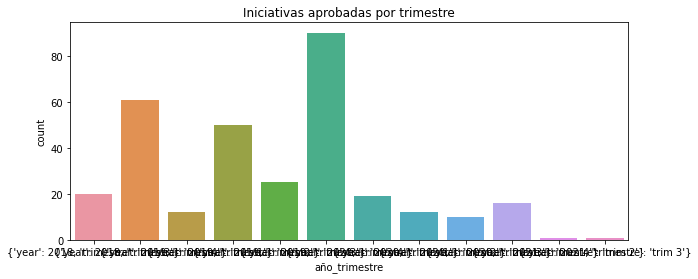

In [67]:
#ordenar los valores
df_trimestres_simple.sort_values(by=['año_trimestre'], ascending=True, inplace=True)

plt.figure(figsize=(10,4))
a = sns.barplot(data=df_trimestres_simple, x='año_trimestre', y='count')
a.set_title("Iniciativas aprobadas por trimestre")
plt.show() # probar sin el plt.show()

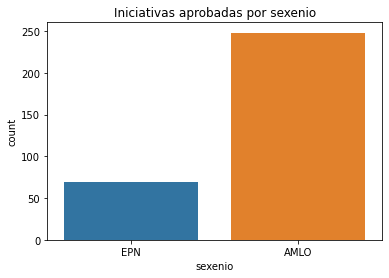

In [72]:
a = sns.barplot(data=df_sexenios[["sexenio","count"]], x='sexenio', y='count')
a.set_title("Iniciativas aprobadas por sexenio")
plt.show() # probar sin el plt.show()

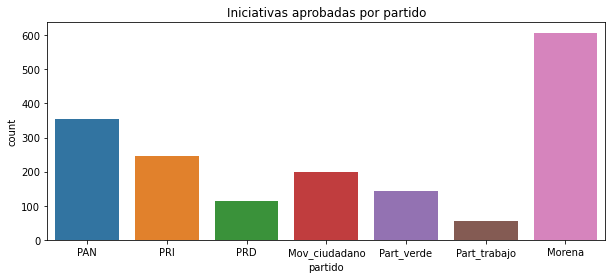

In [73]:
#van a haber repetidas, hay leyes que son de varios partidos

plt.figure(figsize=(10,4))
a = sns.barplot(data=df_partidos[["partido","count"]], x='partido', y='count')
a.set_title("Iniciativas aprobadas por partido")
plt.show() 